# Effects of Educational Attainment and on Family Size

Summary: Fertility rates are declining around the world (Bongaarts and Hodgson, 2022) and while there are multiple factors, this brief study analyzes the relationship of educational attainment of the household head (hereinafter referred to as educational attainment) on family size using data from the Family Income and Expenditure Survey (FIES) conducted by the Philippine Statistics Authority (PSA) in 2017. For convenience, a standard OLS regression, and some preceding tests, was used.

The research determines that<br>
1. There is a statistically significant but very weak negative correlation between educational attainment and family size.
2. Based on the results and visual observation, family size decreases as educational attainment increases

For future studies, one recommendation could be to look at changes in the data over a period of a few years.

In [1]:
### Import family income and expenditure dataset from Kaggle

import kagglehub
import kaggle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import spearmanr
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#configure local path
config_path = 'D:/Jupyter Data Sets' ### note: adjust this if you want to replicate the report

# Authenticate Kaggle API
kaggle.api.authenticate()

# Download the latest version of the dataset
kaggle.api.dataset_download_files(
    dataset='grosvenpaul/family-income-and-expenditure',
    path=config_path,
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/grosvenpaul/family-income-and-expenditure


In [3]:
#Open CSV
file_path = r'D:/Jupyter Data Sets/Family Income and Expenditure.csv'
FIES = pd.read_csv(file_path)
FIES.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


## Step 1: Prepare Educational Attainment column.
### Educational Attainment has many categories in the dataset. Similar levels of education are lumped into ordinal categories as follows:
0 - Preschool or Less<br>
1 - Elementary Graduate or Less<br>
2 - High School Graduate or Less<br>
3 - College Graduate or Less<br>
4 - Postgraduate Studies<br>
5 - Vocational/Technical Programs<br>
6 - Others

In [4]:
#Create new categorical columns to display household head's education level based on "Household Head Highest Grade Completed".
#Categories are from 0-6

FIES.loc[
    FIES["Household Head Highest Grade Completed"].isin([
        "No Grade Completed","Preschool"
    ]),
    "Household Educational Bucket"
] = 0

FIES.loc[
    FIES["Household Head Highest Grade Completed"].isin([
        "Grade 1","Grade 2","Grade 3","Grade 4","Grade 5","Grade 6","Elementary Graduate"
    ]),
    "Household Educational Bucket"
] = 1

FIES.loc[
    FIES["Household Head Highest Grade Completed"].str.contains("High School",case=False),
    "Household Educational Bucket"
] = 2

FIES.loc[
    FIES["Household Head Highest Grade Completed"].str.contains("College",case=False),
    "Household Educational Bucket"
] = 3

FIES.loc[
    FIES["Household Head Highest Grade Completed"].isin([
        "Post Baccalaureate"
    ]),
    "Household Educational Bucket"
] = 4

FIES.loc[
    FIES["Household Head Highest Grade Completed"].str.contains("Programs",case=False),
    "Household Educational Bucket"
] = 5

FIES.loc[
    FIES["Household Educational Bucket"].isnull(),
    "Household Educational Bucket"
] = 6

# Ensure both columns are numeric
FIES['Household Educational Bucket'] = pd.to_numeric(FIES['Household Educational Bucket'], errors='coerce')
FIES['Total Number of Family members'] = pd.to_numeric(FIES['Total Number of Family members'], errors='coerce')

# Drop rows with NaN in either column
FIES = FIES.dropna(subset=['Household Educational Bucket', 'Total Number of Family members'])

## Step 2A: Look for correlations between the variables.
In simple terms, correlation is a measure of the direction one variable changes based on the changes made in another variable.

(e.g. if I eat more food, I notice that my weight increases | positive correlation)

Correlation is measured as a value between -1 (negatively correlated) and 1 (positively correlated) that follows these rules:

0.7 to 1.0 (-0.7 to -1.0): Strong correlation<br>
0.4 to 0.7 (-0.4 to -0.7): Moderate correlation<br>
0.1 to 0.4 (-0.1 to -0.4): Weak correlation<br>
0: No correlation

Example interpretation if the correlation between food and weight is 0.78:<br>

There is a strong positive correlation (__r=0.78__) between food intake and weight, suggesting that higher food intake is associated with higher weight.


In [5]:
# Calculate Spearman correlation and p-value
correlation, p_value = spearmanr(FIES['Total Number of Family members'], FIES['Household Educational Bucket'])

# Print results
print(f'Spearman Correlation: {correlation:.4f}')
print(f'P-Value: {p_value:.4e}')

Spearman Correlation: -0.0531
P-Value: 2.2199e-27


## Step 2B: Interpretation of the results

The correlation coefficient is -0.05 with a p-value less than 0.05.

This means that there is a statistically significant but very weak negative correlation between educational attainment and family size. 

On the other hand, we can see visually below that households with more educated household heads tend to have less family members.

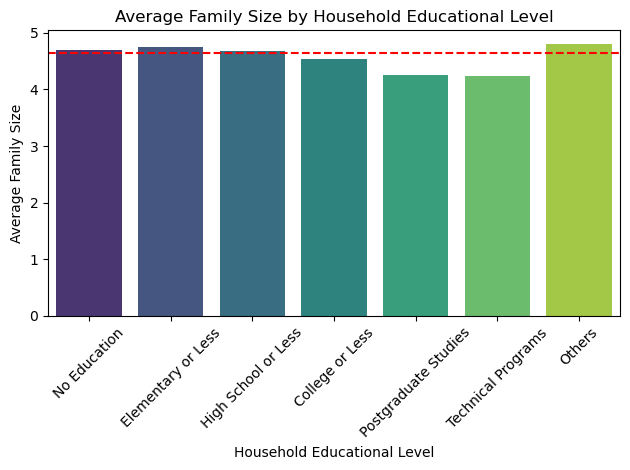

In [6]:
## Visualizing the results of the test

# Calculate average family size per educational bucket
avg_family_size_by_edu = FIES.groupby('Household Educational Bucket')['Total Number of Family members'].mean().reset_index()
avg_family_size = FIES['Total Number of Family members'].mean()

sns.barplot(
    data=avg_family_size_by_edu,
    x='Household Educational Bucket',
    y='Total Number of Family members',
    palette='viridis'
)

# Add labels and title
plt.title('Average Family Size by Household Educational Level')
plt.axhline(y=avg_family_size, color='red', linestyle='--', label=f'Overall Avg: {avg_family_size:.2f}')
plt.xlabel('Household Educational Level')
plt.ylabel('Average Family Size')
plt.xticks(ticks=avg_family_size_by_edu['Household Educational Bucket'], 
           labels=['No Education', 'Elementary or Less', 'High School or Less', 'College or Less', 
                   'Postgraduate Studies', 'Technical Programs', 'Others'],rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

## Step 3A: Linear Regression

Next, we want to use a basic linear regression to understand the gravity of the __impact__ of educational attainment on household income. For the purpose of this project, we will assume that the conditions for OLS have been met:<br>
1. Linearity<br>
2. No endogeneity<br>
3. Homoscedasticity<br>
4. No autocorrelation<br>
5. No multicollinearity

In [7]:
Y = FIES['Total Number of Family members']
X = FIES['Household Educational Bucket']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

# Display the summary
print(model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Total Number of Family members   R-squared:                       0.005
Model:                                        OLS   Adj. R-squared:                  0.005
Method:                             Least Squares   F-statistic:                     198.2
Date:                            Sat, 28 Dec 2024   Prob (F-statistic):           6.42e-45
Time:                                    19:06:09   Log-Likelihood:                -93093.
No. Observations:                           41544   AIC:                         1.862e+05
Df Residuals:                               41542   BIC:                         1.862e+05
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      

## Step 3B: Basic Regression Result Interpretation (Above) 
The results of the regression can be interpreted as follows:<br>
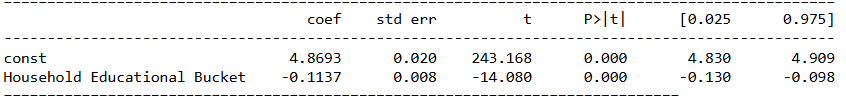
- Constant (const): When educational attainment is preschool or less, the average number of household members is 4.87
- P-Value (P>|t|): The findings are statistically significant
    - P-Value determines whether or not the findings are significant usually based on if they are less than 0.10,0.05, or 0.01
- Household Educational Bucket coefficient = -0.1137
    - __FOR EACH INCREASE IN EDUCATIONAL ATTAINMENT OF THE HOUSEHOLD HEAD, AVERAGE FAMILY SIZE DECREASES BY ABOUT 0.11 MEMBERS__


## Step 3C: Graph Visualization (Below)
We can see a visualization of the regression in the bar graph. It confirms the visual observation that the household head's educational attainment is associated with family size.


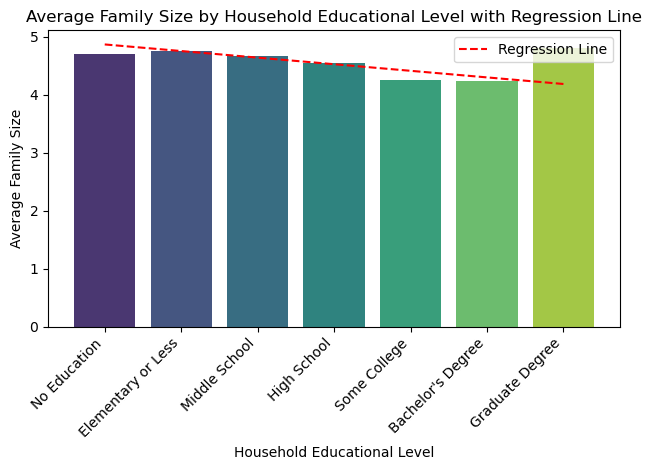

In [8]:
# Regression Model
Y = FIES['Total Number of Family members']
X = FIES['Household Educational Bucket']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

# Bar Plot for Average Family Size by Educational Level
avg_family_size_by_edu = FIES.groupby('Household Educational Bucket')['Total Number of Family members'].mean().reset_index()
sns.barplot(
    data=avg_family_size_by_edu,
    x='Household Educational Bucket',
    y='Total Number of Family members',
    palette='viridis'
)

# Add Regression Line
X_range = np.linspace(X['Household Educational Bucket'].min(), X['Household Educational Bucket'].max(), 100)
X_range_with_const = sm.add_constant(X_range)
Y_pred = model.predict(X_range_with_const)

plt.plot(
    X_range, 
    Y_pred, 
    color='red', 
    linestyle='--', 
    label='Regression Line'
)

# Add Labels and Title
plt.title('Average Family Size by Household Educational Level with Regression Line')
plt.xlabel('Household Educational Level')
plt.ylabel('Average Family Size')

# Custom X-axis Labels
plt.xticks(
    ticks=avg_family_size_by_edu['Household Educational Bucket'], 
    labels=['No Education', 'Elementary or Less', 'Middle School', 
            'High School', 'Some College', "Bachelor's Degree", 'Graduate Degree'], 
    rotation=45, 
    ha='right'
)

# Add Legend
plt.legend()

# Adjust Layout
plt.tight_layout()
plt.show()

## Step 4: Conclusion

The research aims to understand if increasing education in the Philippines is indicative of a lower population like in other countries. In the case of this study, educational attainment of the household head was used to represent education on the household level using data from the 2017 FIES.

While correlation between educational attainment and family size was significantly weak, the regression results and data visualizations showed that there was a significant impact on the number of family members as education level increased.

Future studies can build on the results by adding more independent variables or by checking the validity of the claims over a period of time.

In [10]:
jupyter contrib nbextension install --user

SyntaxError: invalid syntax (1639211862.py, line 1)